In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import json

%matplotlib inline
from itertools import compress

In [2]:
from file_processing import *

In [3]:
org_dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed/'

In [4]:
dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_small/'

In [7]:
dataset_path = 'data/categories_castle_cafe/categories_blurred_photos_removed_small_256/'

In [8]:
for test_c in range(1, 51):
    c_path = os.path.join(dataset_path, str(test_c))
    files = get_filenames(c_path)
    for i, f in enumerate(files):
        cbir_compress_and_save(os.path.join(org_dataset_path, str(test_c), f), os.path.join(dataset_path, str(test_c), f))

In [9]:
img = cv2.imread(os.path.join(dataset_path, '47/bad3.jpg'))

In [10]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [11]:
orb = cv2.ORB_create()

In [12]:
key_points, description = orb.detectAndCompute(img, None)

In [13]:
img_keypoints = cv2.drawKeypoints(img,
                                  key_points,
                                  img, # this actually amends the image
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

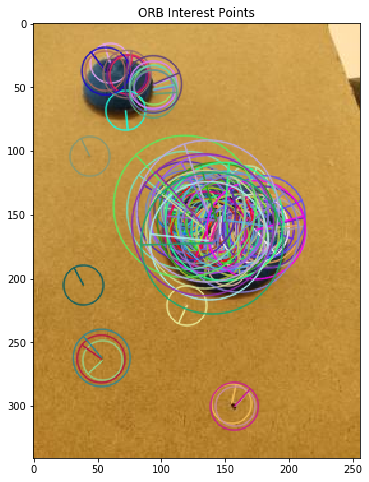

In [14]:
plt.figure(figsize=(8, 8))
plt.title('ORB Interest Points')
plt.imshow(img_keypoints); plt.show()

In [15]:
img = cv2.imread(os.path.join(dataset_path, '47/bad3.jpg'))

In [16]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [17]:
sift = cv2.xfeatures2d.SIFT_create()

In [18]:
key_points, description = sift.detectAndCompute(img, None)

In [19]:
img_keypoints = cv2.drawKeypoints(img,
                                  key_points,
                                  img,
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

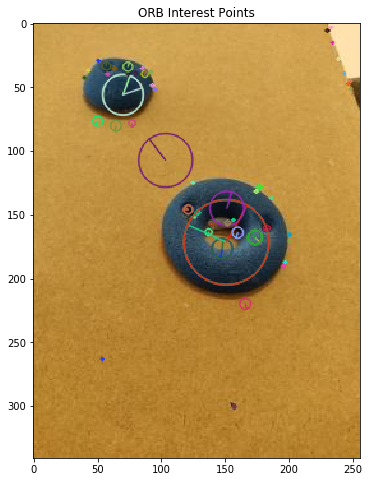

In [20]:
plt.figure(figsize=(8, 8))
plt.title('ORB Interest Points')
plt.imshow(img_keypoints); plt.show()

In [147]:
def image_detect_and_compute(detector, img_name, grey):
    """Detect and compute interest points and their descriptors."""
    img = cv2.imread(os.path.join(dataset_path, img_name))
    if grey:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # The performance is lowered if I use grayscale
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.equalizeHist(img)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, img1_name, img2_name, nmatches=10, ax=False, grey=True):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name, grey)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name, grey)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x: x.distance) # Sort matches by distance.  Best come first.
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:nmatches], img2, flags=2) # Show top 10 matches
    if ax:
        return img_matches, sum([x.distance for x in matches[:nmatches]])
    else:
        print('Total distance:')
        print(sum([x.distance for x in matches[:nmatches]]))
        plt.figure(figsize=(8, 8))
        plt.title(type(detector))
        plt.imshow(img_matches); plt.show()
        return sum([x.distance for x in matches[:nmatches]])

In [148]:
def draw_image_matches_ransac(detector, img1_name, img2_name, ax=False, grey=True):
    """Draw ORB feature matches of the given two images."""
    img1, kp1, des1 = image_detect_and_compute(detector, img1_name, grey)
    img2, kp2, des2 = image_detect_and_compute(detector, img2_name, grey)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = [m for m in matches if m.distance<64]
    
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, img2, flags=2)
    
     # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    
    ransac_matches = list(compress(matches, mask.squeeze().tolist()))
    ransac_img_matches = cv2.drawMatches(img1, kp1, img2, kp2, ransac_matches, img2, flags=2) # Show distance<64 matches

    if ax:
        return ransac_img_matches, -len(ransac_matches)
    else:
        print('Total distance:')
        print(sum([x.distance for x in matches]))
        plt.figure(figsize=(8, 8))
        plt.title(type(detector))
        plt.imshow(ransac_img_matches); plt.show()
        return -len(ransac_matches)


Total distance:
1808.0


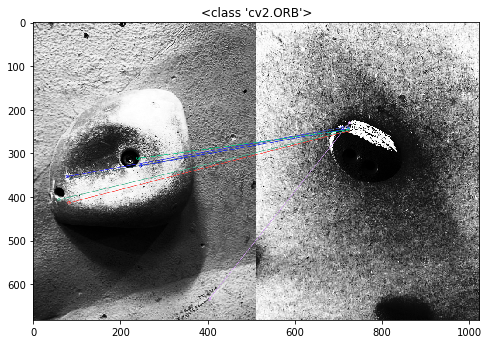

-7

In [149]:
draw_image_matches_ransac(orb, '42/IMG_20191215_092637646.jpg', '49/bad7.jpg')

#### Get the prod descriptors and images

In [8]:
route_images = pd.read_csv('route_images_descriptors.csv')

In [9]:
route_images['imagefilename'] = route_images.path.apply(lambda x: x.split('/')[8].replace('_IMG', '/IMG'))

In [10]:
descriptors_kps = {}

In [11]:
# first generate descriptors and keypoints for routes already in prod
orb = cv2.ORB_create()
for i, row in route_images.iterrows(): 
    _, kp, des = image_detect_and_compute(orb, row['imagefilename'])
    descriptors_kps[row['imagefilename']] = {'descriptors': des, 'keypoints': kp}

In [12]:
# now add the addtional routes
for test_c in range(47, 51):
    c_path = os.path.join(dataset_path, str(test_c))
    files = get_filenames(c_path)
    for f in files:
        if 'route' in f:
            _, kp, des = image_detect_and_compute(orb, f'{test_c}/{f}')
            descriptors_kps[f'{test_c}/{f}'] = {'descriptors': des, 'keypoints': kp}

Adding additional routes to reproduce prod

In [81]:
extended_route_images = route_images.drop('imagefilename', axis=1).copy()
extended_route_images = extended_route_images.append([extended_route_images.loc[0]]*4, ignore_index=True)
# extended_route_images.loc[150]['route_id'] = 47
extended_route_images.iat[150, 0] = 47
extended_route_images.iat[150, -1] = json.dumps(descriptors['47/route1.jpg'].tolist())
extended_route_images.iat[150, -3] = "dummy_path1"
extended_route_images.iat[151, 0] = 48
extended_route_images.iat[151, -1] = json.dumps(descriptors['47/route2.jpg'].tolist())
extended_route_images.iat[151, -3] = "dummy_path2"
extended_route_images.iat[152, 0] = 49
extended_route_images.iat[152, -1] = json.dumps(descriptors['47/route3.jpg'].tolist())
extended_route_images.iat[152, -3] = "dummy_path3"
extended_route_images.iat[153, 0] = 50
extended_route_images.iat[153, -1] = json.dumps(descriptors['47/route4.jpg'].tolist())
extended_route_images.iat[153, -3] = "dummy_path4"

In [83]:
extended_route_images.to_csv('route_images_extended.csv', index=False)

Test it out

In [80]:
def match_img(matcher, orb, img_name, descriptors, nmatches, grey=True):
    _, _, des = image_detect_and_compute(orb, img_name, grey)
    dists = {}
    for file_name, detect_d in descriptors.items():
        des_i = detect_d['descriptors']
        if img_name!=file_name: # prevent matching on itself
            matches = matcher.match(des, des_i)
            matches = sorted(matches, key = lambda x: x.distance)
            dist = sum([x.distance for x in matches[:nmatches]])
            dists[file_name] = dist
    return dists

In [81]:
def match_img_count(matcher, orb, img_name, descriptors, nmatches, grey=True):
    _, _, des = image_detect_and_compute(orb, img_name, grey)
    dists = {}
    for file_name, detect_d in descriptors.items():
        des_i = detect_d['descriptors']
        if img_name!=file_name: # prevent matching on itself
            matches = matcher.match(des, des_i)
            matches = [m for m in matches if m.distance<64]
            dists[file_name] = -len(matches)
    return dists

In [82]:
def match_img_ransac(matcher, orb, img_name, descriptors, nmatches, grey=True):
    
    _, kp, des = image_detect_and_compute(orb, img_name, grey)
    dists = {}
    for file_name, detect_d in descriptors.items():
        des_i = detect_d['descriptors']
        kp_i = detect_d['keypoints']
        if img_name!=file_name: # prevent matching on itself
            matches = matcher.match(des, des_i)
            matches = [m for m in matches if m.distance<64]  # ransac should be on good matches only
#             matches.sort(key=lambda x: x.distance, reverse=False)
#             GOOD_MATCH_PERCENT = 0.5
#             num_good_matches = int(len(matches) * GOOD_MATCH_PERCENT)
#             matches = matches[:num_good_matches]
            
            # Extract location of good matches
            points1 = np.zeros((len(matches), 2), dtype=np.float32)
            points2 = np.zeros((len(matches), 2), dtype=np.float32)

            for i, match in enumerate(matches):
                points1[i, :] = kp[match.queryIdx].pt
                points2[i, :] = kp_i[match.trainIdx].pt
            h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    
            ransac_matches = list(compress(matches, mask.squeeze().tolist()))

#             dists[file_name] = -len(ransac_matches)
            ransac_matches = sorted(ransac_matches, key = lambda x: x.distance)
            dists[file_name] =  sum([x.distance for x in ransac_matches[:5]])
    return dists

In [33]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [34]:
d = match_img_ransac(bf, orb, '49/bad7.jpg', descriptors_kps, 10)

In [35]:
min(d, key=d.get)

'2/IMG_20191215_092136.jpg'

This is a problem! The distance is shorter than with other images

Total distance:
487.0


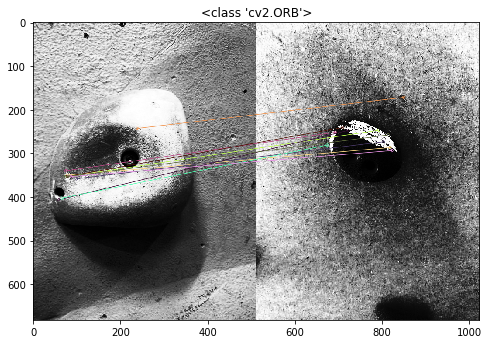

487.0

In [150]:
draw_image_matches(orb, '42/IMG_20191215_092637646.jpg', '49/bad7.jpg', nmatches=10)

In [130]:
def get_min_dists(d):
    min_dists = {}
    for c_f, v in d.items():
        min_dist_key = min(v, key=v.get)
        min_dist_dist = min(v.values())
        min_dist_c = min_dist_key.split('/')[0]
#         min_dists[c_f] = [min_dist_c, min_dist_dist]
        min_dists[c_f] = [min_dist_key, min_dist_dist]
    return min_dists

def distinct(seq):
    # distinct elements in list preserving order
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def get_top_n(d, n=3):
    top_n = {}
    for c_f, v in d.items():
        s = sorted(v, key=v.get)
        distinct_s = distinct([i.split('/')[0] for i in s])  # gets the category out of the image file name
        top_n[c_f] = distinct_s[:n]
    return top_n
    
def get_stats(d):
    min_dists = get_min_dists(d)
    correct = []
    wrong = []
    for c_f, v in min_dists.items():
        if c_f.split('/')[0] == v[0].split('/')[0]:
            correct.append(v[1])  # v[1] is ditsnace v[0] is the predicted f_c
        else:
            wrong.append(v[1])   
    max_correct = max(correct)
    print(f"Max correct: {max_correct}")
    min_wrong = min(wrong)
    print(f"Min wrong: {min_wrong}")
    print(f"Total number of images: {(len(correct)+len(wrong))}")
    print(f"Number wrong: {len(wrong)}")
    number_wrong_below_threshold = len([x for x in wrong if x<max_correct])
    print(f"Number wrong below threshold: {number_wrong_below_threshold}")
    print(f"% wrong below max correct: {round(number_wrong_below_threshold/(len(correct)+len(wrong)), 2)*100}%")
    print(f"% wrong overall: {round(len(wrong)/(len(correct)+len(wrong)), 2)*100}%")
    top_n = get_top_n(d)
    correct_top_3 = []
    wrong_top_3 = []
    for c_f, cats in top_n.items():
        if any(i==c_f.split('/')[0] for i in cats):
            correct_top_3.append(c_f)
        else:
            wrong_top_3.append(c_f)  
    print(f"% wrong overall top 3: {round(len(wrong_top_3)/(len(correct_top_3)+len(wrong_top_3)), 2)*100}%")

Run from here

In [151]:
NO_MATCHES = 5

In [152]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [153]:
# Match all images
d = {}
start = time.time()
MAX_FEATURES = 500
orb = cv2.ORB_create(MAX_FEATURES)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for c in range(47, 51):
    c_path = os.path.join(dataset_path, str(c))
    files = get_filenames(c_path)
    for i, f in enumerate(files):
        if 'route' not in f:  # because we prevent matching on itself which is the true answer
#             print(f)
            dists = match_img(bf, orb, f'{c}/{f}', descriptors_kps, NO_MATCHES, grey=True)
            d[f'{c}/{f}'] = dists
print(f"Time elapsed: {time.time() - start}")

Time elapsed: 13.712814807891846


In [154]:
get_stats(d)

Max correct: 218.0
Min wrong: 120.0
Total number of images: 33
Number wrong: 24
Number wrong below threshold: 20
% wrong below max correct: 61.0%
% wrong overall: 73.0%
% wrong overall top 3: 57.99999999999999%


With current implementation 39%

With NMATCHES=100 took 2s longer, 73% wrong!

With sum of dists less than 64: 97% wrong lol

With 64 threshold and NMATCHES=10: 42% wrong

Removing <64 didn't make things better

Grayscale now made things better and helped with the chalk!
But on the previosu method grayscale makes it worse.

With ransac on new dataset: Taking forever. 36% wrong.

TO DO:

1. Implement runnable RANSAC and so that you can choose the old method as well

2. Try it with and without grayscale

3. Check if the performance is better

4. If not, do further parameter tuning

In [136]:
min_dists = get_min_dists(d)

In [137]:
correct = []
wrong = []
wrong_dists = []
for c_f, v in min_dists.items():
    if c_f.split('/')[0] == v[0].split('/')[0]:
        correct.append(v[1])
    else:
        wrong.append(c_f) 
        wrong_dists.append(v[1]) 

In [138]:
wrong

['47/good18.jpg',
 '47/good1.jpg',
 '47/bad5.jpg',
 '47/bad3.jpg',
 '47/good11.jpg',
 '48/good19.jpg',
 '48/bad6.jpg',
 '48/good7.jpg',
 '48/bad8.jpg',
 '49/good21.jpg',
 '49/good16.jpg',
 '50/bad4.jpg',
 '50/bad1.jpg',
 '50/bad_tricky1.jpg',
 '50/bad_tricky2.jpg']

In [139]:
min_dists

{'47/good18.jpg': ['16/IMG_20191212_215304247.jpg', 129.0],
 '47/good1.jpg': ['12/IMG_20191124_204748.jpg', 157.0],
 '47/bad5.jpg': ['16/IMG_20191212_215304247.jpg', 146.0],
 '47/bad3.jpg': ['16/IMG_20191212_215304247.jpg', 145.0],
 '47/good9.jpg': ['47/route1.jpg', 154.0],
 '47/good10.jpg': ['47/route1.jpg', 153.0],
 '47/good11.jpg': ['20/IMG_20191124_204912.jpg', 163.0],
 '48/good_tricky2.jpg': ['48/route2.jpg', 141.0],
 '48/good19.jpg': ['35/IMG_20191212_215543318.jpg', 165.0],
 '48/good_tricky1.jpg': ['48/route2.jpg', 128.0],
 '48/good22.jpg': ['48/route2.jpg', 105.0],
 '48/bad6.jpg': ['35/IMG_20191212_215543318.jpg', 154.0],
 '48/bad2.jpg': ['48/route2.jpg', 150.0],
 '48/good7.jpg': ['20/IMG_20191215_092320.jpg', 149.0],
 '48/good8.jpg': ['48/route2.jpg', 168.0],
 '48/bad8.jpg': ['35/IMG_20191212_215543318.jpg', 174.0],
 '48/good12.jpg': ['48/route2.jpg', 120.0],
 '49/good20.jpg': ['49/route3.jpg', 128.0],
 '49/good21.jpg': ['35/IMG_20191212_215543318.jpg', 176.0],
 '49/bad7.jpg':

The one really up close is still wrong and prefers the screws keypoints

Chalky hold is still a bit of a problem, but only one. 

Need to check whether this is overall an improvement. 

In [ ]:
fig, ax = plt.subplots(len(wrong), 4, figsize=(20,80))
NMATCHES = 10

for n, img_name in enumerate(wrong):
    imgmatches, dist = draw_image_matches(orb,
                                       img_name,
                                       min_dists[img_name][0],
                                       NMATCHES,
                                       True, False)
    ax[n, 0].imshow(imgmatches)
    ax[n, 0].set_xlabel(dist)
    category = img_name.split('/')[0]
    files = get_filenames(os.path.join(dataset_path, category))

    imgmatches, dist = draw_image_matches(orb,
                                   img_name,
                                   min_dists[img_name][0],
                                   5,
                                   True)
    ax[n, 2].imshow(imgmatches)
    ax[n, 2].set_xlabel(dist)
    category = img_name.split('/')[0]
    files = get_filenames(os.path.join(dataset_path, category))
    for f in files:
         if 'route' in f:
            imgmatches, dist = draw_image_matches(orb, img_name, 
                                               f'{category}/{f}',
                                               NMATCHES,
                                               True, False
                                              )
            ax[n, 1].imshow(imgmatches)
            ax[n, 1].set_xlabel(dist)
            imgmatches, dist = draw_image_matches(orb,
                                                   img_name,
                                                   f'{category}/{f}',
                                                   5,
                                                   True,
                                                   )
            ax[n, 3].imshow(imgmatches)
            ax[n, 3].set_xlabel(dist)
    